# UK Bird Population Trends - Identifying Patterns With Population Declines 


# 1. Loading & Understanding the CSV  

In [1]:
# Importing all the packages necessary for analysis. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import zscore 
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Loading CSV and assigning to variable (df) 

df = pd.read_csv('data/all_species_index_species_trends_England_1970_to_2014_rev 2.csv')

In [3]:
# Displaying all columns, data types and non-null counts within df.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   type                                 121 non-null    object 
 1   date                                 121 non-null    object 
 2   species                              121 non-null    object 
 3   Long term change  percentage change  115 non-null    object 
 4   Long term Annual percentage change   115 non-null    float64
 5   Trend                                115 non-null    object 
 6   date.1                               121 non-null    object 
 7   Short term percentage change         121 non-null    int64  
 8   Annual percentage change             121 non-null    float64
 9   Trend.1                              121 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 9.6+ KB



Type refers to habitat.
Date is a long term range between 1970 and 2014.
Date.1 is a short-term range (2009-2014). 

In [4]:
df['type'].unique()

columns_to_check = ['type', 'date', 'date.1']

for col in columns_to_check:
    if df[col].dtype == 'object':
        print(f"Unique values in column '{col}': {df[col].unique()}")

Unique values in column 'type': ['Farmland Generalists (7)' 'Farmland Specialists (12)'
 'Woodland Generalists (12)' 'Woodland Specialists (22)'
 'Water and wetland Birds of fast flowing water (4)'
 'Water and wetland Reedbed Birds (4)'
 'Water and wetland Birds of slow and standing water (6)'
 'Wetland Birds (8)' 'Other Species (4)' 'Seabirds (13)'
 'Other species included in the all species indicator (31)']
Unique values in column 'date': ['1970 - 2014' '1975 - 2014' '1986 - 2014' '1970 -  2013']
Unique values in column 'date.1': ['2009 - 2014']


In [5]:
# Loading 2nd CSV - Afro-Palearctic migrant birds 1994-2008. Assigning to variable (df2)  

df2 = pd.read_csv('data/T0001-10.1080_00063657.2011.645798.csv')
# https://www.tandfonline.com/doi/epdf/10.1080/00063657.2011.645798?needAccess=true

# 2. Data Cleaning

# 2.1 Finding Missing Values

In [6]:
# There are 6 null values in 3 columns

print(df.isna().sum())

# The null values span 6 entries
# These can be seen below 

print(len(df[df.isnull().any(axis=1)]))
df[df.isnull().any(axis=1)]

type                                   0
date                                   0
species                                0
Long term change  percentage change    6
Long term Annual percentage change     6
Trend                                  6
date.1                                 0
Short term percentage change           0
Annual percentage change               0
Trend.1                                0
dtype: int64
6


,type,date,species,Long term change percentage change,Long term Annual percentage change,Trend,date.1,Short term percentage change,Annual percentage change,Trend.1
69,Wetland Birds (8),1975 - 2014,Little Egret (Egretta garzetta),NaN,NaN,NaN,2009 - 2014,26,4.76,strong increase
99,Other species included in the all species indi...,1970 - 2013,Firecrest (Regulus ignicapilla),NaN,NaN,NaN,2009 - 2014,171,22.02,strong increase
105,Other species included in the all species indi...,1970 - 2013,Mediterranean Gull (Larus melanocephalus),NaN,NaN,NaN,2009 - 2014,19,3.53,strong increase
112,Other species included in the all species indi...,1970 - 2013,Red Kite (Milvus milvus),NaN,NaN,NaN,2009 - 2014,100,14.88,strong increase
114,Other species included in the all species indi...,1970 - 2013,Shoveler (Anas clypeata),NaN,NaN,NaN,2009 - 2014,8,1.49,weak increase
115,Other species included in the all species indi...,1970 - 2013,Stone Curlew (Burhinus oedicnemus),NaN,NaN,NaN,2009 - 2014,14,2.63,weak increase


# 2.2 Reformatting Columns 

In [7]:
# Renaming columns
# I've shortened column names for greater readability before capitalising to fix inconsistent format. 

print(df.columns)

df.rename(columns={'Long term change  percentage change': 'Long Term Change', 
                   'Short term percentage change': 'Short Term Change',
                   'Long term Annual percentage change': 'Long Term Annual Change', 
                   'Annual percentage change': 'Short Term annual Change'
                  }, inplace=True)

df.columns = df.columns.str.title()

Index(['type', 'date', 'species', 'Long term change  percentage change',
       'Long term Annual percentage change', 'Trend', 'date.1',
       'Short term percentage change', 'Annual percentage change', 'Trend.1'],
      dtype='object')


In [8]:
# The brackets in some 'Long Term Change' values mean the column has an object dtype making analysis difficult. 
# I've created a numerical version to fix this.

def split_number(value):
    if isinstance(value, str): 
        split = value.split()
        return split[-1] if len(split) > 1 else split[0]  
    return value  

df['Long Term Change Cleaned'] = df['Long Term Change'].astype(str).apply(split_number)
df['Long Term Change Cleaned'] = pd.to_numeric(df['Long Term Change Cleaned'], errors='coerce')

# Moving 'Species' column to the left, the cleaned long term change column next to other long term columns and checking that all the changes worked.

species_column = df.pop('Species')
df.insert(0, 'Species', species_column)
ltc_column = df.pop('Long Term Change Cleaned')
df.insert(3, 'Long Term Change Cleaned', ltc_column)
print(df.columns)
df.tail()

Index(['Species', 'Type', 'Date', 'Long Term Change Cleaned',
       'Long Term Change', 'Long Term Annual Change', 'Trend', 'Date.1',
       'Short Term Change', 'Short Term Annual Change', 'Trend.1'],
      dtype='object')


,Species,Type,Date,Long Term Change Cleaned,Long Term Change,Long Term Annual Change,Trend,Date.1,Short Term Change,Short Term Annual Change,Trend.1
116,Stonechat (Saxicola rubicola),Other species included in the all species indi...,1970 - 2013,26.0,(1995-2014) 26,1.20,weak increase,2009 - 2014,-27,-5.99,strong decline
117,Swallow (Hirundo rustica),Other species included in the all species indi...,1970 - 2013,9.0,9,0.20,no change,2009 - 2014,-8,-1.74,weak decline
118,Swift (Apus apus),Other species included in the all species indi...,1970 - 2013,-46.0,(1995-2014) -46,-3.21,strong decline,2009 - 2014,-21,-4.70,strong decline
119,Whinchat (Saxicola rubetra),Other species included in the all species indi...,1970 - 2013,-37.0,(1995-2014) -37,-2.41,weak decline,2009 - 2014,22,4.03,strong increase
120,Woodlark (Lullula arborea),Other species included in the all species indi...,1970 - 2013,250.0,(1980-2014) 250,3.75,strong increase,2009 - 2014,18,3.39,strong increase


# 2.3 Checking for Duplicates 

Although there are no true duplicates, habitats within the type column end in a bracketed number representing the number of species within that habitat category. 
There are inconsistencies between this number and the value count for some habitats, suggesting there are multiple entries for some species

In [9]:
print(f"Number of duplicates = {df.duplicated().sum()}")

print(df['Type'].value_counts())

# The above theory is confirmed here
# 3 species have multiple entries 


species_counts = df.groupby('Species').size()

multiple_entries_species = species_counts[species_counts > 1]

print()
print("Species with Multiple Entries:")
print(multiple_entries_species)


Number of duplicates = 0
Type
Other species included in the all species indicator (31)    31
Woodland Specialists (22)                                   22
Woodland Generalists (12)                                   12
Seabirds (13)                                               11
Farmland Specialists (12)                                   11
Farmland Generalists (7)                                     8
Wetland Birds (8)                                            8
Water and wetland Birds of slow and standing water (6)       6
Water and wetland Birds of fast flowing water (4)            4
Water and wetland Reedbed Birds (4)                          4
Other Species (4)                                            4
Name: count, dtype: int64

Species with Multiple Entries:
Species
Lapwing (Vanellus vanellus)            2
Reed Bunting (Emberiza schoeniclus)    2
Yellow Wagtail (Motacilla flava)       2
dtype: int64


At times the corresponding trends differ between multiple entries for single species.

However, this may not indicate an issue since these entries have different type (habitat) values and date ranges suggesting that either of these factors could account for the differing trends. 


In [10]:
multiple_entries_species_i = species_counts[species_counts > 1].index
duplicates_df = df[df['Species'].isin(multiple_entries_species_i)]
sorted_duplicates_df = duplicates_df.sort_values(by='Species')
sorted_duplicates_df

,Species,Type,Date,Long Term Change Cleaned,Long Term Change,Long Term Annual Change,Trend,Date.1,Short Term Change,Short Term Annual Change,Trend.1
10,Lapwing (Vanellus vanellus),Farmland Specialists (12),1970 - 2014,-50.0,-50,-1.58,weak decline,2009 - 2014,-20,-4.34,strong decline
68,Lapwing (Vanellus vanellus),Wetland Birds (8),1975 - 2014,-2.0,(1980-2015) -2,-0.06,no change,2009 - 2014,-35,-8.28,strong decline
3,Reed Bunting (Emberiza schoeniclus),Farmland Generalists (7),1970 - 2014,-30.0,-30,-0.82,no change,2009 - 2014,8,1.46,weak increase
58,Reed Bunting (Emberiza schoeniclus),Water and wetland Reedbed Birds (4),1975 - 2014,-52.0,-52,-1.89,weak decline,2009 - 2014,-10,-2.14,weak decline
6,Yellow Wagtail (Motacilla flava),Farmland Generalists (7),1970 - 2014,-66.0,-66,-2.41,weak decline,2009 - 2014,24,4.44,strong increase
74,Yellow Wagtail (Motacilla flava),Wetland Birds (8),1975 - 2014,-97.0,-97,-8.38,strong decline,2009 - 2014,-31,-7.23,strong decline


# 2.4 Detecting Outliers 

There are 3 outlier entries. 

It's likely that they involve extreme but valid values, since populations of all 3 species are known to have changed dramatically. 


In [11]:
numeric_df = df.select_dtypes(include=[np.number])

z_scores = numeric_df.apply(zscore)

threshold = 3
outliers = (z_scores > threshold) | (z_scores < -threshold)

rows_with_outliers = outliers.any(axis=1)

outlier_rows = df[rows_with_outliers]

outlier_rows

,Species,Type,Date,Long Term Change Cleaned,Long Term Change,Long Term Annual Change,Trend,Date.1,Short Term Change,Short Term Annual Change,Trend.1
16,Turtle Dove (Streptopelia turtur),Farmland Specialists (12),1970 - 2014,-97.0,-97,-8.01,strong decline,2009 - 2014,-70,-21.45,strong decline
99,Firecrest (Regulus ignicapilla),Other species included in the all species indi...,1970 - 2013,NaN,NaN,NaN,NaN,2009 - 2014,171,22.02,strong increase
112,Red Kite (Milvus milvus),Other species included in the all species indi...,1970 - 2013,NaN,NaN,NaN,NaN,2009 - 2014,100,14.88,strong increase


# 3. The Big Picture

Comparison between long term and short term trend categories reveals a higher proportion of strong increase and decrease in short term trends.


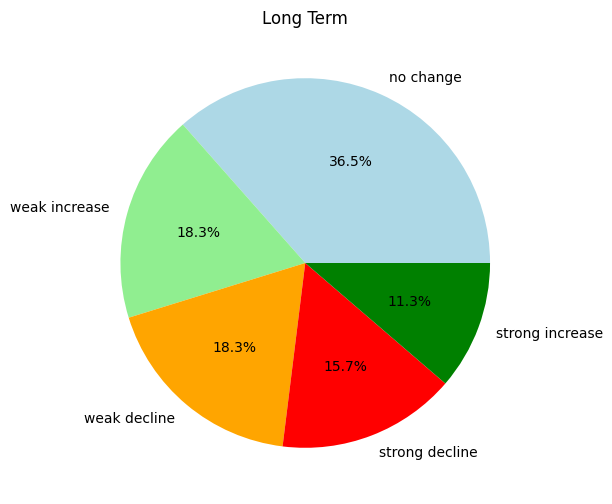

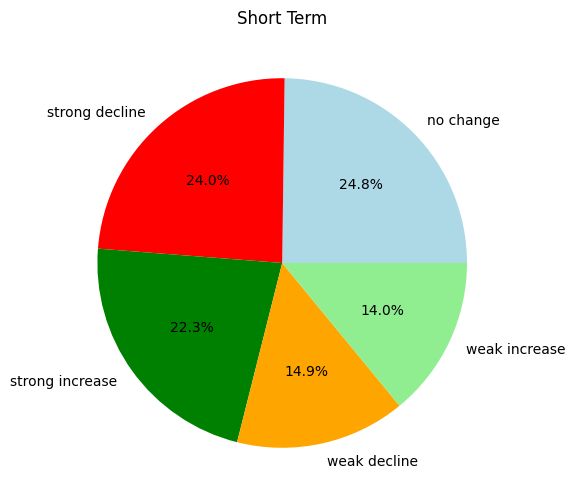

In [12]:
# Define the specific colors for each category
custom_colors = {
    "strong decline": "red",
    "weak decline": "orange",
    "no change": "lightblue",
    "weak increase": "lightgreen",
    "strong increase": "green"
}

unique_trend_categories = df['Trend'].value_counts().index
unique_trend1_categories = df['Trend.1'].value_counts().index

color_map = {category: custom_colors.get(category, "grey") for category in unique_trend_categories.union(unique_trend1_categories)}

plt.figure(figsize=(12, 6))
plt.pie(df['Trend'].value_counts(), 
        labels=df['Trend'].value_counts().index, 
        autopct='%1.1f%%',
        colors=[color_map[cat] for cat in df['Trend'].value_counts().index])
plt.title("Long Term")
plt.show()

plt.figure(figsize=(12, 6))
plt.pie(df['Trend.1'].value_counts(), 
        labels=df['Trend.1'].value_counts().index, 
        autopct='%1.1f%%',
        colors=[color_map[cat] for cat in df['Trend.1'].value_counts().index])
plt.title("Short Term")
plt.show()

There is a positive correlation between species’ short term annual change and long term annual change.

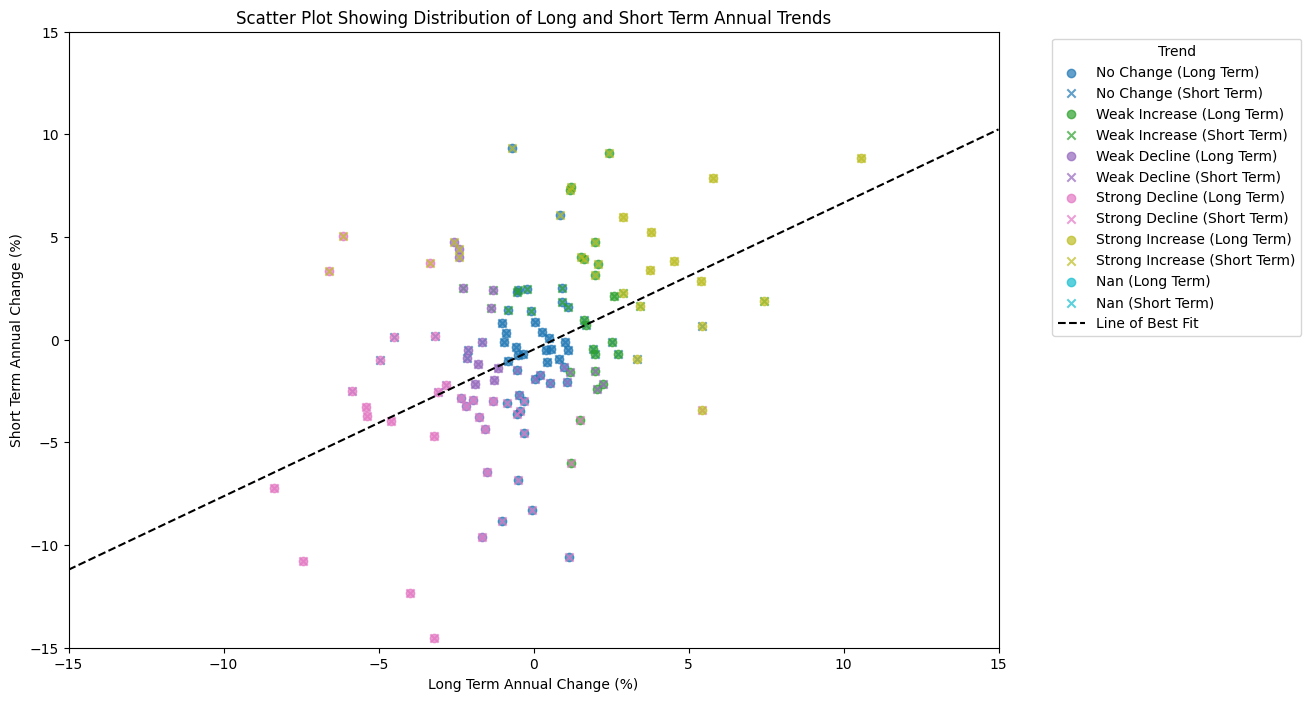

In [13]:
unique_trends = pd.concat([df['Trend'], df['Trend.1']]).unique()
colors = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_trends))) 
plt.figure(figsize=(12, 8))

for i, trend in enumerate(unique_trends):
    # Long Term Trend
    subset_long = df[df['Trend'] == trend]
    plt.scatter(subset_long['Long Term Annual Change'], 
                subset_long['Short Term Annual Change'], 
                color=colors[i], 
                label=f'{str(trend).title()} (Long Term)', 
                alpha=0.7)

    # Short Term Trend
    subset_short = df[df['Trend.1'] == trend]
    plt.scatter(subset_short['Long Term Annual Change'], 
                subset_short['Short Term Annual Change'], 
                color=colors[i], 
                marker='x',  
                label=f'{str(trend).title()} (Short Term)', 
                alpha=0.7)

all_long_term = pd.concat([df['Long Term Annual Change'], df['Long Term Annual Change']])
all_short_term = pd.concat([df['Short Term Annual Change'], df['Short Term Annual Change']])

valid_indices = np.isfinite(all_long_term) & np.isfinite(all_short_term)
all_long_term = all_long_term[valid_indices]
all_short_term = all_short_term[valid_indices]

if len(all_long_term) > 1 and len(all_short_term) > 1 and np.var(all_long_term) > 0 and np.var(all_short_term) > 0:
    try:
        slope, intercept = np.polyfit(all_long_term, all_short_term, 1)
        line_of_best_fit = slope * np.array([-15, 15]) + intercept

        # Plot the line of best fit
        plt.plot([-15, 15], line_of_best_fit, color='black', linestyle='--', label='Line of Best Fit')
    except np.linalg.LinAlgError:
        print("Error in computing the line of best fit. Possibly due to insufficient or constant data.")
else:
    print("Insufficient or constant data, unable to compute a line of best fit.")

plt.xlim(-15, 15)
plt.ylim(-15, 15)

plt.xlabel('Long Term Annual Change (%)')
plt.ylabel('Short Term Annual Change (%)')
plt.title('Scatter Plot Showing Distribution of Long and Short Term Annual Trends')
plt.legend(title='Trend', bbox_to_anchor=(1.05, 1), loc='upper left')  

plt.show()

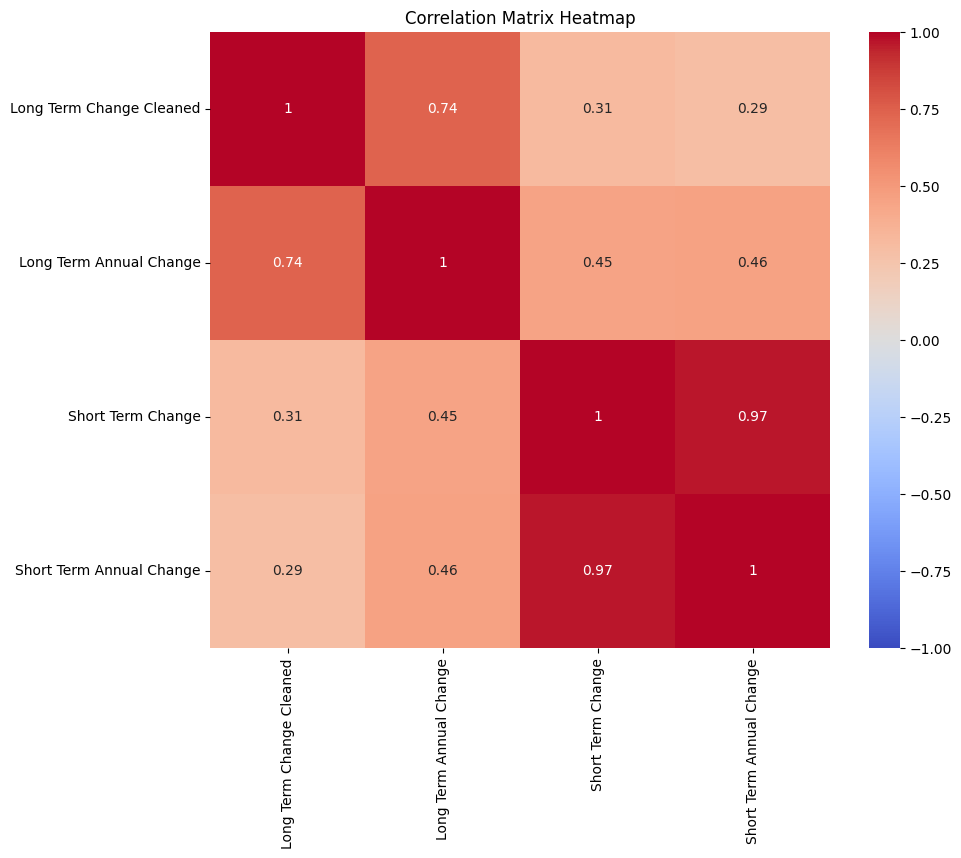

In [14]:
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

No extra information was provided with the CSV to explain how trend/trend.1 values have been calculated.

Below I've created a plot to test the hypothesis that trend/trend.1 categories correspond to annual change.

To do this I've generated a scatter plot to observe the spread of annual change values and created lines to represent the max and min annual change for each trend category. 


The category ranges are non-overlapping, supporting my hypothesis.

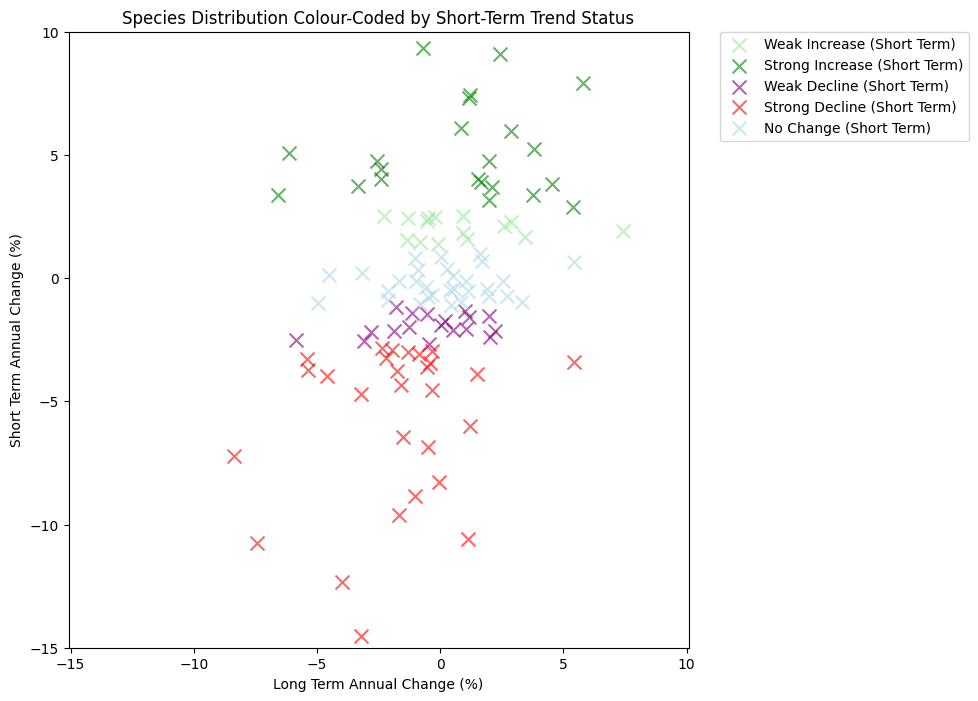

In [15]:
colors = {
    'weak increase': 'lightgreen',
    'strong increase': 'green',
    'weak decline': 'purple',
    'strong decline': 'red',
    'no change': 'lightblue'
}

plt.figure(figsize=(8, 8))  

for trend in colors:
    subset = df[df['Trend.1'] == trend]
    plt.scatter(subset['Long Term Annual Change'], 
                subset['Short Term Annual Change'], 
                c=colors[trend], 
                marker='x',  
                s=100,   
                label=f'{trend.title()} (Short Term)', 
                alpha=0.6)  

plt.xlim(-15, 10)
plt.ylim(-15, 10)

plt.gca().set_aspect('equal', adjustable='datalim')

plt.xlabel('Long Term Annual Change (%)')
plt.ylabel('Short Term Annual Change (%)')
plt.title('Species Distribution Colour-Coded by Short-Term Trend Status')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

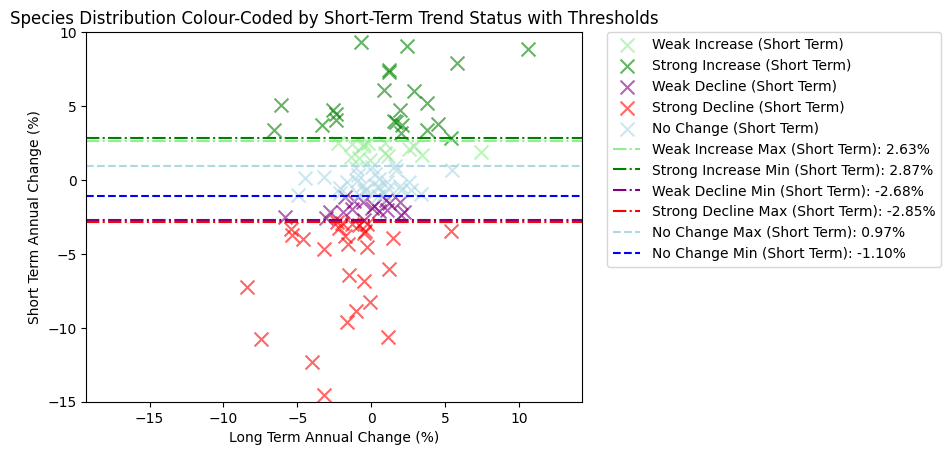

In [16]:
# Plot short-term trends

# Calculate the max and min values for the long-term and short-term trends
no_change_max = df[df['Trend'] == 'no change']['Long Term Annual Change'].max()
no_change_min = df[df['Trend'] == 'no change']['Long Term Annual Change'].min()
weak_increase_max = df[df['Trend'] == 'weak increase']['Long Term Annual Change'].max()
strong_increase_min = df[df['Trend'] == 'strong increase']['Long Term Annual Change'].min()
weak_decline_min = df[df['Trend'] == 'weak decline']['Long Term Annual Change'].min()
strong_decline_max = df[df['Trend'] == 'strong decline']['Long Term Annual Change'].max()

no_change_max1 = df[df['Trend.1'] == 'no change']['Short Term Annual Change'].max()
no_change_min1 = df[df['Trend.1'] == 'no change']['Short Term Annual Change'].min()
weak_increase_max1 = df[df['Trend.1'] == 'weak increase']['Short Term Annual Change'].max()
strong_increase_min1 = df[df['Trend.1'] == 'strong increase']['Short Term Annual Change'].min()
weak_decline_min1 = df[df['Trend.1'] == 'weak decline']['Short Term Annual Change'].min()
strong_decline_max1 = df[df['Trend.1'] == 'strong decline']['Short Term Annual Change'].max()

for trend in colors:
    subset1 = df[df['Trend.1'] == trend]
    plt.scatter(subset1['Long Term Annual Change'], 
                subset1['Short Term Annual Change'], 
                c=colors[trend], 
                marker='x',  
                s=100,   
                label=f'{trend.title()} (Short Term)', 
                alpha=0.6)  

# Set the x and y limits to run from -15 to 10
plt.xlim(-15, 10)
plt.ylim(-15, 10)

# Ensure the aspect ratio is equal
plt.gca().set_aspect('equal', adjustable='datalim')

# Add horizontal lines to indicate the cut-off points for short-term trends
plt.axhline(y=weak_increase_max1, color='lightgreen', linestyle='-.', label=f'Weak Increase Max (Short Term): {weak_increase_max1:.2f}%')
plt.axhline(y=strong_increase_min1, color='green', linestyle='-.', label=f'Strong Increase Min (Short Term): {strong_increase_min1:.2f}%')
plt.axhline(y=weak_decline_min1, color='purple', linestyle='-.', label=f'Weak Decline Min (Short Term): {weak_decline_min1:.2f}%')
plt.axhline(y=strong_decline_max1, color='red', linestyle='-.', label=f'Strong Decline Max (Short Term): {strong_decline_max1:.2f}%')
plt.axhline(y=no_change_max1, color='lightblue', linestyle='--', label=f'No Change Max (Short Term): {no_change_max1:.2f}%')
plt.axhline(y=no_change_min1, color='blue', linestyle='--', label=f'No Change Min (Short Term): {no_change_min1:.2f}%')

# Add labels and title
plt.xlabel('Long Term Annual Change (%)')
plt.ylabel('Short Term Annual Change (%)')
plt.title('Species Distribution Colour-Coded by Short-Term Trend Status with Thresholds')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Show the plot
plt.show()

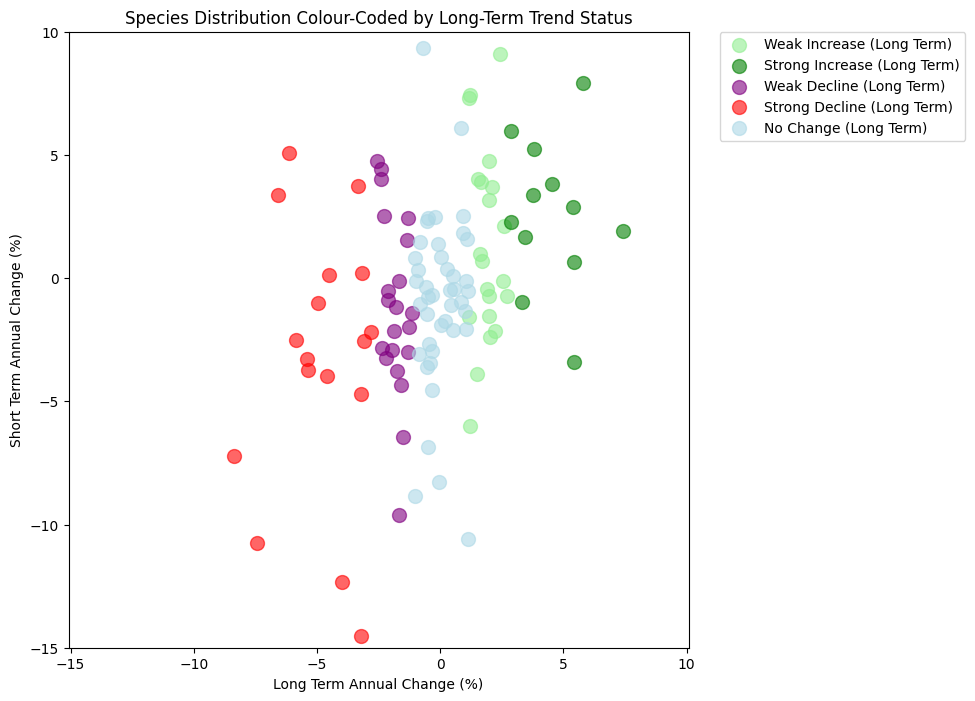

In [17]:
plt.figure(figsize=(8, 8))  

for trend in colors:
    subset = df[df['Trend'] == trend]
    plt.scatter(subset['Long Term Annual Change'], 
                subset['Short Term Annual Change'], 
                c=colors[trend], 
                marker='o',  
                s=100,   
                label=f'{trend.title()} (Long Term)', 
                alpha=0.6)  

plt.xlim(-15, 10)
plt.ylim(-15, 10)

plt.gca().set_aspect('equal', adjustable='datalim')

plt.xlabel('Long Term Annual Change (%)')
plt.ylabel('Short Term Annual Change (%)')
plt.title('Species Distribution Colour-Coded by Long-Term Trend Status')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

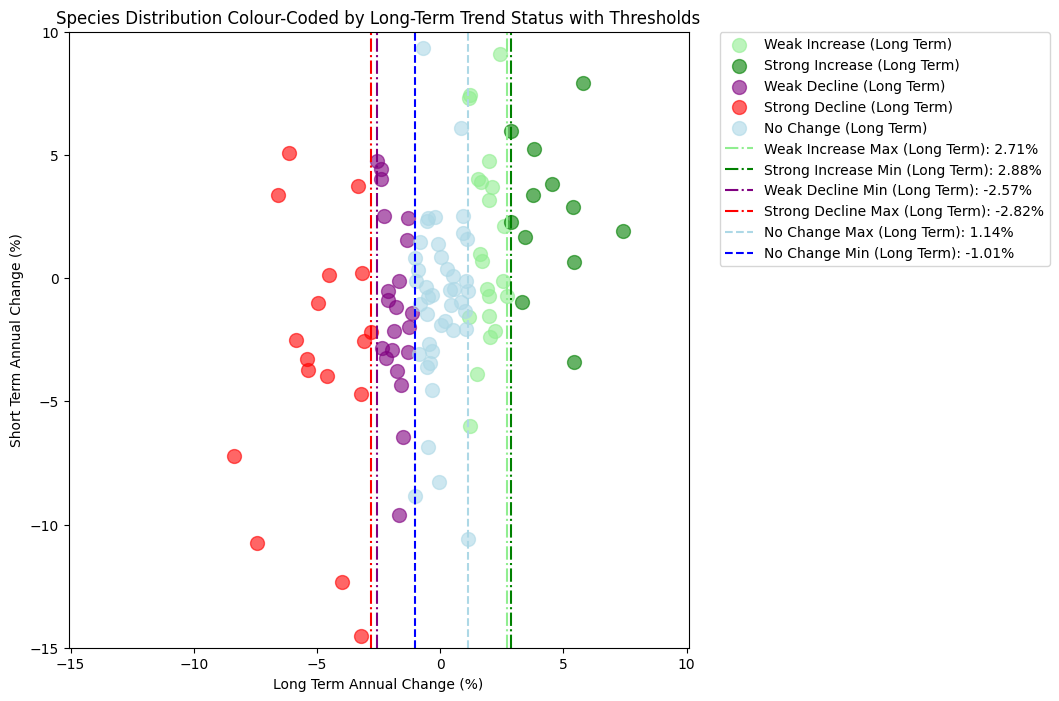

In [18]:
plt.figure(figsize=(8, 8))  # Make the figure square

# Plot long-term trends
for trend in colors:
    subset = df[df['Trend'] == trend]
    plt.scatter(subset['Long Term Annual Change'], 
                subset['Short Term Annual Change'], 
                c=colors[trend], 
                marker='o',  
                s=100,   
                label=f'{trend.title()} (Long Term)', 
                alpha=0.6)  

# Set the limits for x and y axes
plt.xlim(-15, 10)
plt.ylim(-15, 10)

# Ensure the aspect ratio is equal
plt.gca().set_aspect('equal', adjustable='datalim')

# Add vertical lines to indicate the cut-off points for long-term trends
plt.axvline(x=weak_increase_max, color='lightgreen', linestyle='-.', label=f'Weak Increase Max (Long Term): {weak_increase_max:.2f}%')
plt.axvline(x=strong_increase_min, color='green', linestyle='-.', label=f'Strong Increase Min (Long Term): {strong_increase_min:.2f}%')
plt.axvline(x=weak_decline_min, color='purple', linestyle='-.', label=f'Weak Decline Min (Long Term): {weak_decline_min:.2f}%')
plt.axvline(x=strong_decline_max, color='red', linestyle='-.', label=f'Strong Decline Max (Long Term): {strong_decline_max:.2f}%')
plt.axvline(x=no_change_max, color='lightblue', linestyle='--', label=f'No Change Max (Long Term): {no_change_max:.2f}%')
plt.axvline(x=no_change_min, color='blue', linestyle='--', label=f'No Change Min (Long Term): {no_change_min:.2f}%')

# Add labels and title
plt.xlabel('Long Term Annual Change (%)')
plt.ylabel('Short Term Annual Change (%)')
plt.title('Species Distribution Colour-Coded by Long-Term Trend Status with Thresholds')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Show the plot
plt.show()

# 4. Species In Decline 

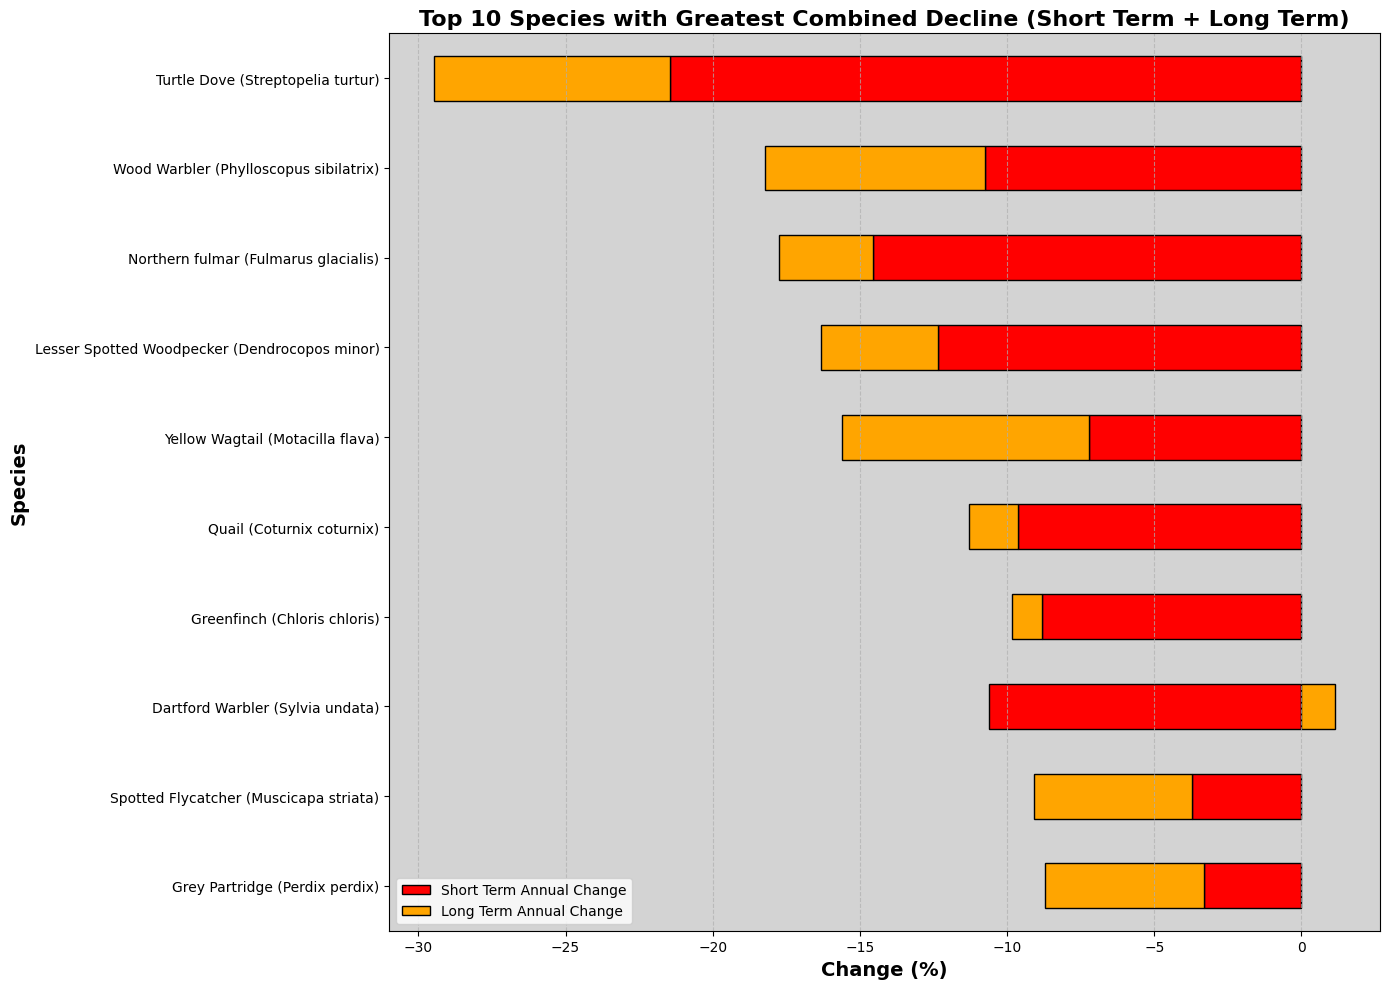

In [19]:
# The graph below shows the top 10 species with greatest combined decline (short term annual + long term annual)

df['Combined Decline'] = df['Short Term Annual Change'] + df['Long Term Annual Change']

top_combined_decline = df.nsmallest(10, 'Combined Decline')[['Species', 'Short Term Annual Change', 'Long Term Annual Change', 'Combined Decline']]
top_combined_decline.sort_values(by='Combined Decline', ascending=False, inplace=True)
top_combined_decline.set_index('Species', inplace=True)

plt.figure(figsize=(14, 10))

ax = top_combined_decline[['Short Term Annual Change', 'Long Term Annual Change']].plot(
    kind='barh', 
    stacked=True, 
    color=['red', 'orange'], 
    edgecolor='black', 
    ax=plt.gca()
)

plt.gca().set_facecolor('lightgrey')  
plt.grid(axis='x', linestyle='--', alpha=0.7)  
plt.xlabel('Change (%)', fontsize=14, fontweight='bold')
plt.ylabel('Species', fontsize=14, fontweight='bold')
plt.title('Top 10 Species with Greatest Combined Decline (Short Term + Long Term)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

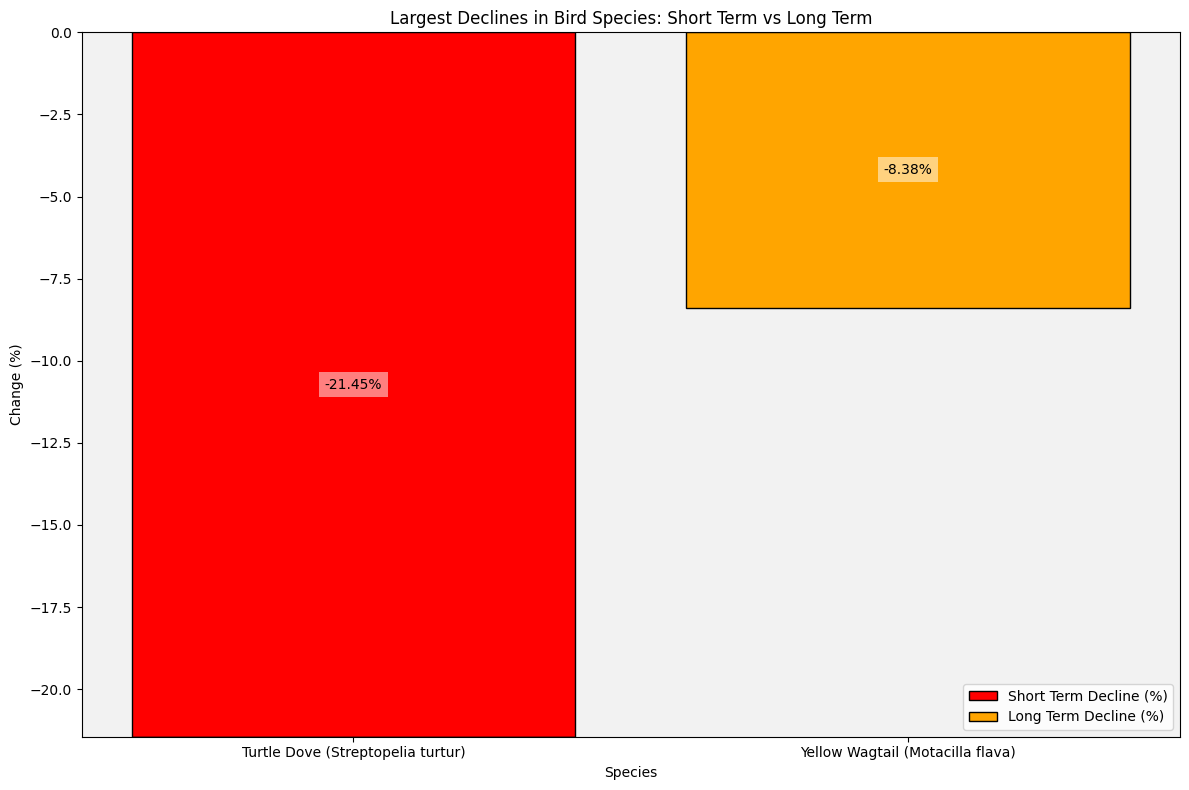

In [20]:
# Turtle doves have suffered the largest annual short term decline whereas yellow wagtail have suffered the largest annual long term 

st_annual_decline_sp = df.loc[df['Short Term Annual Change'].idxmin()]['Species']
st_annual_decline_value = df['Short Term Annual Change'].min()

lt_annual_decline_sp = df.loc[df['Long Term Annual Change'].idxmin()]['Species']
lt_annual_decline_value = df['Long Term Annual Change'].min()

species = [st_annual_decline_sp, lt_annual_decline_sp]
short_term_decline = [st_annual_decline_value, 0]  
long_term_decline = [0, lt_annual_decline_value]  

plt.figure(figsize=(12, 8))

bars1 = plt.bar(species, short_term_decline, color='red', edgecolor='black', label='Short Term Decline (%)')
bars2 = plt.bar(species, long_term_decline, bottom=short_term_decline, color='orange', edgecolor='black', label='Long Term Decline (%)')

plt.xlabel('Species')
plt.ylabel('Change (%)')
plt.title('Largest Declines in Bird Species: Short Term vs Long Term')
plt.legend()

for i, bar in enumerate(bars1):
    height = bar.get_height()
    if height != 0:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height / 2,
            f'{height:.2f}%',
            va='center',
            ha='center',
            color='black',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.5)
        )

for i, bar in enumerate(bars2):
    height = bar.get_height()
    if height != 0:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            short_term_decline[i] + height / 2,
            f'{height:.2f}%',
            va='center',
            ha='center',
            color='black',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.5)
        )

plt.gca().patch.set_facecolor('#f2f2f2')

plt.tight_layout()

plt.show()



# 5. Risk Factors for Population Decline

# 5.1 Habitat

In [21]:
# Of the species categorised by type 'Woodland Specialists' are most common in long and short term strong decline 

long_type = df[df['Trend'] == 'strong decline']['Type'].value_counts()
short_type = df[df['Trend.1'] == 'strong decline']['Type'].value_counts()

print(long_type, short_type)

Type
Woodland Specialists (22)                                   7
Farmland Specialists (12)                                   4
Other species included in the all species indicator (31)    3
Wetland Birds (8)                                           2
Farmland Generalists (7)                                    1
Seabirds (13)                                               1
Name: count, dtype: int64 Type
Other species included in the all species indicator (31)    8
Farmland Specialists (12)                                   4
Woodland Specialists (22)                                   4
Wetland Birds (8)                                           3
Seabirds (13)                                               3
Farmland Generalists (7)                                    2
Water and wetland Birds of slow and standing water (6)      2
Water and wetland Birds of fast flowing water (4)           1
Water and wetland Reedbed Birds (4)                         1
Other Species (4)                 

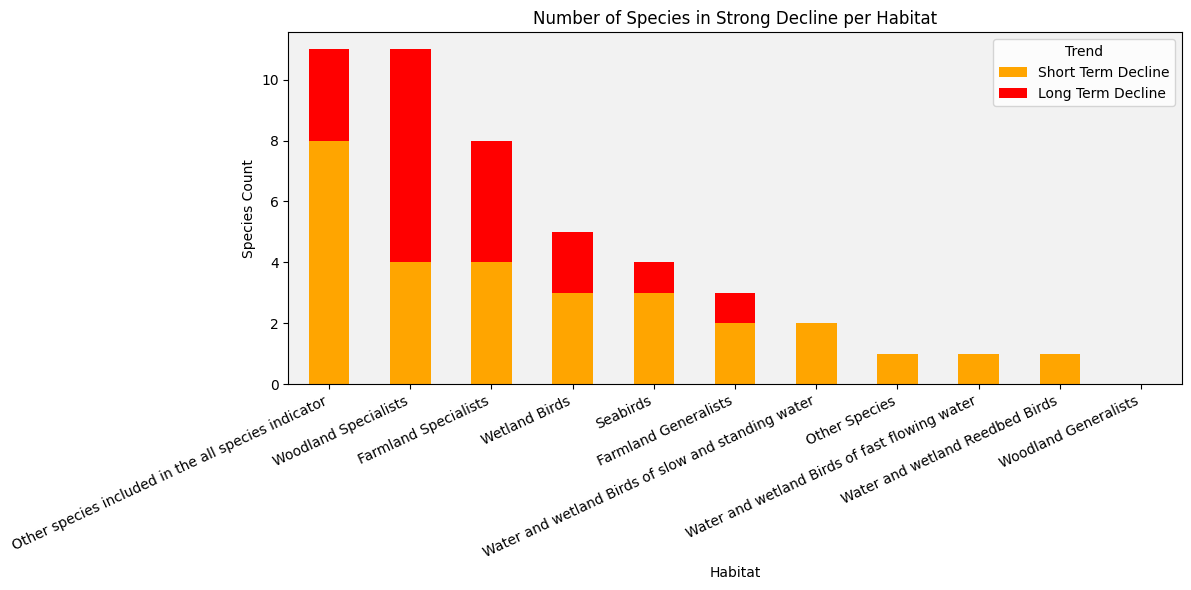

In [22]:
df['Strong Short Term Decline'] = df['Trend.1'] == 'strong decline'
df['Strong Long Term Decline'] = df['Trend'] == 'strong decline'

combined_df = df.groupby('Type').agg({
    'Strong Short Term Decline': 'sum',
    'Strong Long Term Decline': 'sum'
})

combined_df.rename(columns={
    'Strong Short Term Decline': 'Short Term Decline',
    'Strong Long Term Decline': 'Long Term Decline'
}, inplace=True)

combined_df.index = combined_df.index.str.replace(r'\s*\(\d+\)$', '', regex=True)

combined_df['Total Decline'] = combined_df['Short Term Decline'] + combined_df['Long Term Decline']
combined_df.sort_values(by='Total Decline', ascending=False, inplace=True)
combined_df.drop(columns='Total Decline', inplace=True)  # Drop the helper column

plt.figure(figsize=(12, 6))  

combined_df.plot(kind='bar', stacked=True, color=['orange', 'red'], ax=plt.gca())

plt.xlabel('Habitat')
plt.ylabel('Species Count')
plt.title('Number of Species in Strong Decline per Habitat')
plt.legend(title='Trend')

plt.xticks(rotation=25, ha='right')

plt.gca().patch.set_facecolor('#f2f2f2')

plt.tight_layout()

plt.show()

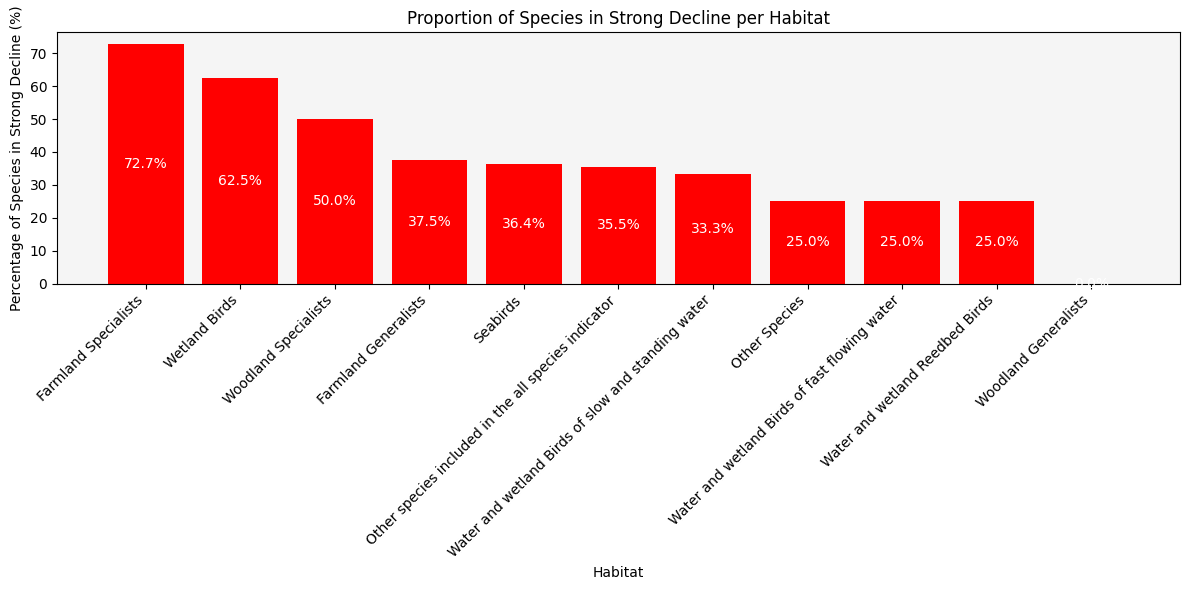

In [23]:
# Farmland specialists category has the largest proportion of species in strong decline.

decline_trends = ['strong decline']

long_term_decline = df[df['Trend'].isin(decline_trends)]
short_term_decline = df[df['Trend.1'].isin(decline_trends)]

decline_df = pd.merge(long_term_decline[['Species', 'Type']], short_term_decline[['Species', 'Type']], how='outer', on='Species')

decline_df = decline_df.rename(columns={'Type_x': 'Type_long_term', 'Type_y': 'Type_short_term'})

species_count_per_habitat_long_term = decline_df.groupby('Type_long_term')['Species'].nunique()
species_count_per_habitat_short_term = decline_df.groupby('Type_short_term')['Species'].nunique()

combined_species_count = species_count_per_habitat_long_term.add(species_count_per_habitat_short_term, fill_value=0)

total_species_per_habitat = df.groupby('Type')['Species'].nunique()

decline_summary = pd.DataFrame({
    'Species in Strong Decline': combined_species_count,
    'Total Species': total_species_per_habitat
}).fillna(0)  

decline_summary['Proportion in Strong Decline (%)'] = (decline_summary['Species in Strong Decline'] / decline_summary['Total Species']) * 100

decline_summary.index = decline_summary.index.str.replace(r'\s*\(\d+\)$', '', regex=True)

decline_summary = decline_summary.sort_values(by='Proportion in Strong Decline (%)', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(decline_summary.index, decline_summary['Proportion in Strong Decline (%)'], color='red')

plt.gca().set_facecolor('#f5f5f5') 

plt.xlabel('Habitat')
plt.ylabel('Percentage of Species in Strong Decline (%)')
plt.title('Proportion of Species in Strong Decline per Habitat')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval / 2, f'{yval:.1f}%', ha='center', va='center', color='white', fontsize=10)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()

plt.show()

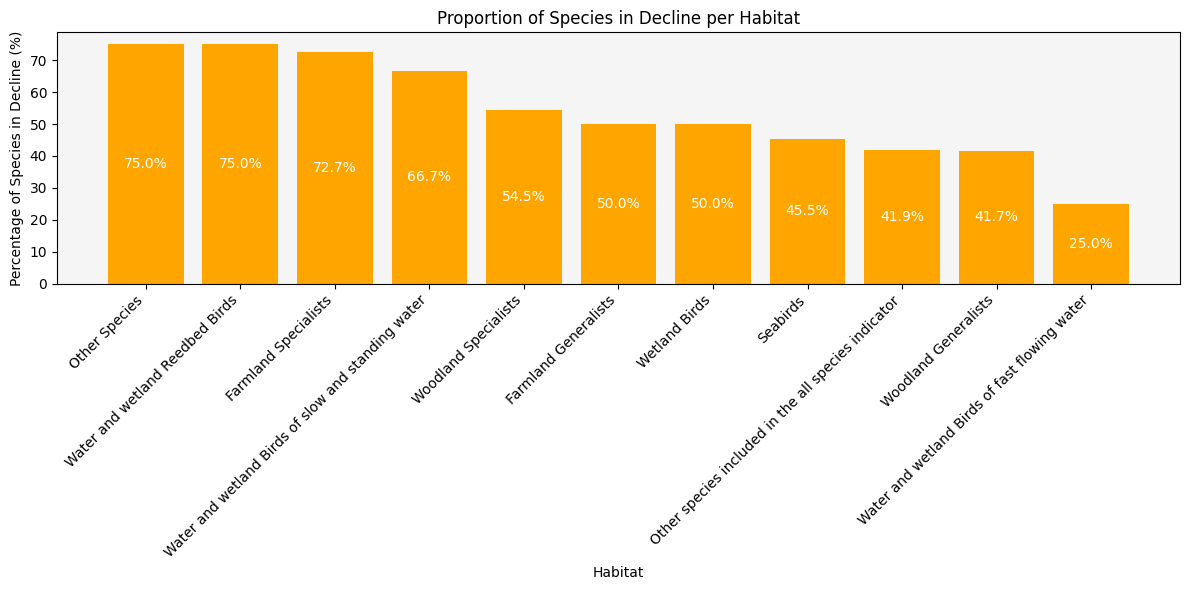

In [24]:
# Water and wetland reedbed birds category has the largest proportion of species in decline (strong or weak)

decline_trends = ['strong decline', 'weak decline']

long_term_decline = df[df['Trend'].isin(decline_trends)]
short_term_decline = df[df['Trend.1'].isin(decline_trends)]

long_term_decline_unique = long_term_decline.drop_duplicates(subset=['Type', 'Species'])
short_term_decline_unique = short_term_decline.drop_duplicates(subset=['Type', 'Species'])

combined_decline = pd.concat([long_term_decline_unique, short_term_decline_unique]).drop_duplicates(subset=['Type', 'Species'])

combined_decline_counts = combined_decline.groupby('Type').size()

total_species_counts = df.groupby('Type').size()

proportions = (combined_decline_counts / total_species_counts) * 100

proportions_df = proportions.reset_index(name='Proportion in Decline')

proportions_df = proportions_df.sort_values(by='Proportion in Decline', ascending=False)

def clean_label(label):
    return re.sub(r'\s*\(\d+\)', '', label)

plt.figure(figsize=(12, 6))
bars = plt.bar(proportions_df['Type'], proportions_df['Proportion in Decline'], color='orange')

plt.gca().set_facecolor('#f5f5f5')  # Light gray background for the plot area

plt.xlabel('Habitat')
plt.ylabel('Percentage of Species in Decline (%)')
plt.title('Proportion of Species in Decline per Habitat')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval / 2, f'{yval:.1f}%', ha='center', va='center', color='white', fontsize=10)

current_labels = [item.get_text() for item in plt.gca().get_xticklabels()]
cleaned_labels = [clean_label(label) for label in current_labels]
plt.xticks(ticks=plt.gca().get_xticks(), labels=cleaned_labels, rotation=45, ha='right')

plt.tight_layout()

plt.show()

Comparing grouped habitat types, we can see that farmland has the greatest proportion of species in decline. 

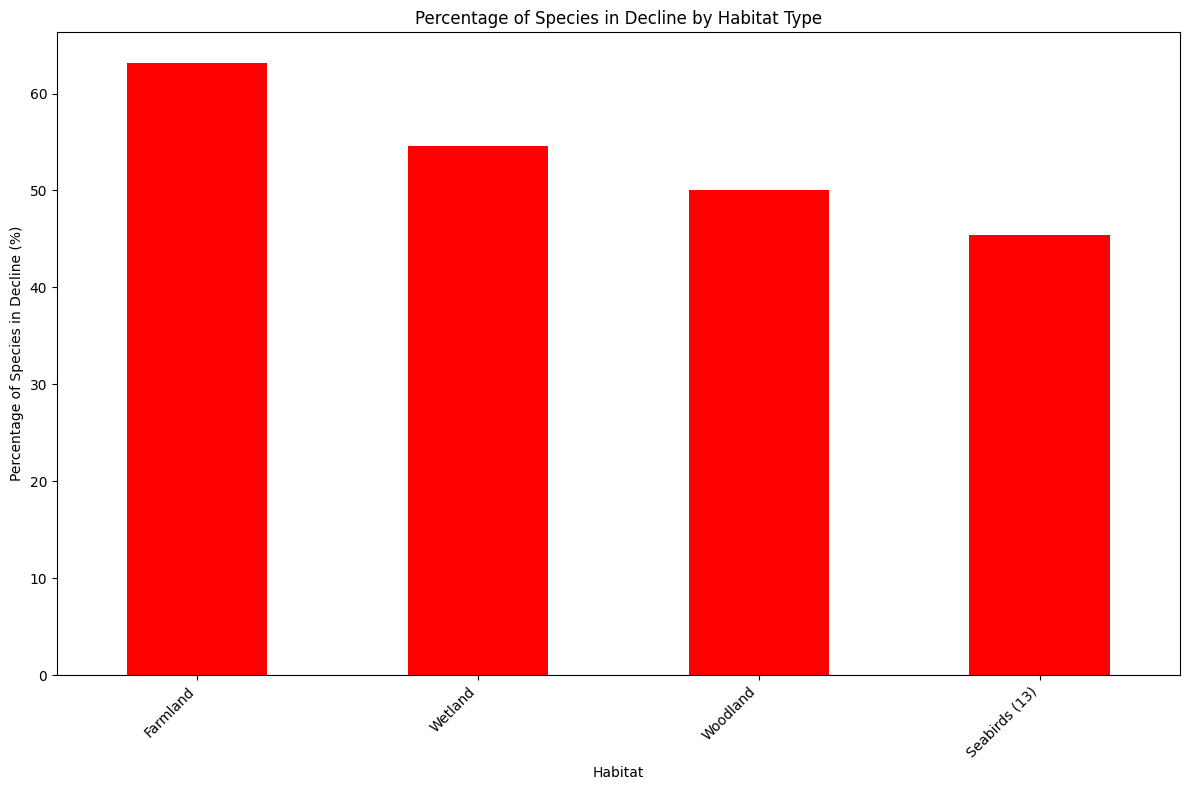

In [25]:
def group_habitat(habitat):
    habitat = habitat.lower()  
    if 'wetland' in habitat:
        return 'Wetland'
    elif 'woodland' in habitat:
        return 'Woodland'
    elif 'farmland' in habitat:
        return 'Farmland'
    else:
        return habitat.title()  
    
df['Grouped Habitat'] = df['Type'].apply(group_habitat)

df_filtered = df[~df['Grouped Habitat'].isin(['Other Species (4)', 'Other Species Included In The All Species Indicator (31)'])]

decline_df = df_filtered[(df_filtered['Trend'].str.contains('decline')) | (df_filtered['Trend.1'].str.contains('decline'))]

total_species_by_grouped_habitat = df_filtered['Grouped Habitat'].value_counts()

species_in_decline_by_grouped_habitat = decline_df['Grouped Habitat'].value_counts()

percentage_in_decline_grouped = (species_in_decline_by_grouped_habitat / total_species_by_grouped_habitat) * 100

percentage_in_decline_grouped = percentage_in_decline_grouped.sort_values(ascending=False)

percentage_in_decline_grouped.plot(kind='bar', figsize=(12, 8), color='red')

plt.xlabel('Habitat')
plt.ylabel('Percentage of Species in Decline (%)')
plt.title('Percentage of Species in Decline by Habitat Type')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()  
plt.show()

However, it looks like this is mostly driven by the farmland specialists. More generally, specialist habitat types have a greater proportion of species in strong decline when compared to generalist habitat types. Specialists are largely dependent on a particular habitat whereas generalists can adapt to a range of habitats.

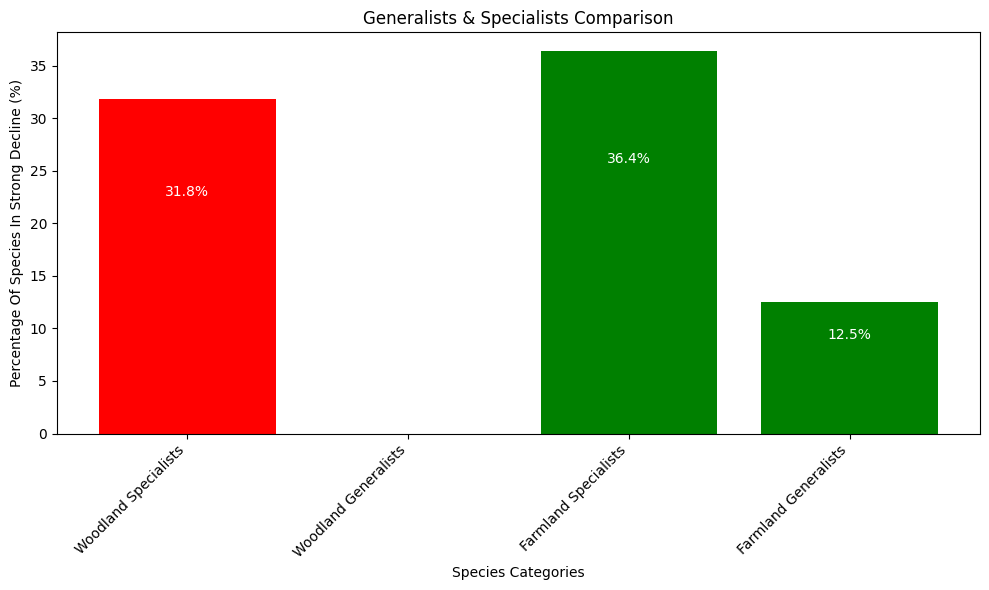

In [26]:
ws_sd_species = df[(df['Type'] == 'Woodland Specialists (22)') & (df['Trend'] == 'strong decline')]['Species'].unique()
ws_sd_count = len(ws_sd_species)
ws_total_species = df[df['Type'] == 'Woodland Specialists (22)']['Species'].unique()
ws_count = len(ws_total_species)

wg_sd_species = df[(df['Type'] == 'Woodland Generalists (12)') & (df['Trend'] == 'strong decline')]['Species'].unique()
wg_sd_count = len(wg_sd_species)
wg_total_species = df[df['Type'] == 'Woodland Generalists (12)']['Species'].unique()
wg_count = len(wg_total_species)

fg_sd_species = df[(df['Type'] == 'Farmland Generalists (7)') & (df['Trend'] == 'strong decline')]['Species'].unique()
fg_sd_count = len(fg_sd_species)
fg_total_species = df[df['Type'] == 'Farmland Generalists (7)']['Species'].unique()
fg_count = len(fg_total_species)

fs_sd_species = df[(df['Type'] == 'Farmland Specialists (12)') & (df['Trend'] == 'strong decline')]['Species'].unique()
fs_sd_count = len(fs_sd_species)
fs_total_species = df[df['Type'] == 'Farmland Specialists (12)']['Species'].unique()
fs_count = len(fs_total_species)

def percent(sd_count, total_count):
    if total_count == 0:
        return 0  
    return (sd_count / total_count) * 100

ws_percent = percent(ws_sd_count, ws_count)
wg_percent = percent(wg_sd_count, wg_count)
fs_percent = percent(fs_sd_count, fs_count)
fg_percent = percent(fg_sd_count, fg_count)

labels = ['Woodland Specialists', 'Woodland Generalists', 'Farmland Specialists', 'Farmland Generalists']
percentages = [ws_percent, wg_percent, fs_percent, fg_percent]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, percentages, color=['red', 'red', 'green', 'green'])
plt.title('Generalists & Specialists Comparison')
plt.xlabel('Species Categories')
plt.ylabel('Percentage Of Species In Strong Decline (%)')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  
        height - (height * 0.3),             
        f'{height:.1f}%',                   
        ha='center',                         
        va='bottom',                         
        color='white'                        
    )

plt.tight_layout()
plt.show()

# 5.2 Migratory Status 

df2 comprises a subset of migratory UK species that overwinter in Africa (summer migrants in the UK).
To explore any correlations between migratory status and population trends, it is useful to merge the dataframes. 
Some formatting is necessary to extract a common name for each species in order to merge.

In [27]:
def extract_common_name_df(species_name):
    if "(" in species_name:
        return species_name.split("(")[0].strip()
    return species_name

def extract_common_name_df2(species_name):
    if "," in species_name:
        return species_name.split(",")[0].strip()
    return species_name

def clean_common_name(name):
    prefixes_to_remove = ['Eurasian', 'European', 'Common', 'Barn']
    words = name.split()  
    cleaned_words = [word for word in words if word not in prefixes_to_remove]
    cleaned_name = ' '.join(cleaned_words)
    return cleaned_name

df['common_name'] = df['Species'].apply(extract_common_name_df)
df2['common_name'] = df2['Species'].apply(extract_common_name_df2)

df['common_name_cleaned'] = df['common_name'].apply(clean_common_name)
df2['common_name_cleaned'] = df2['common_name'].apply(clean_common_name)

merged_df = pd.merge(df, df2, on='common_name_cleaned', how='inner')
merged_df.head()

,Species_x,Type,Date,Long Term Change Cleaned,Long Term Change,Long Term Annual Change,Trend,Date.1,Short Term Change,Short Term Annual Change,...,common_name_x,common_name_cleaned,Species_y,Bioclimatic zone,Winter habitat,Breeding season habitat,Trend in arrival date (days/year),Median arrival date*,BBS trend % annual change 1994–2008 (± se),common_name_y
0,Yellow Wagtail (Motacilla flava),Farmland Generalists (7),1970 - 2014,-66.0,-66,-2.41,weak decline,2009 - 2014,24,4.44,...,Yellow Wagtail,Yellow Wagtail,"Yellow Wagtail, Motacilla flava",Arid,Open,General,–0.09,130.0,–4.44 (± 0.75),Yellow Wagtail
1,Turtle Dove (Streptopelia turtur),Farmland Specialists (12),1970 - 2014,-97.0,-97,-8.01,strong decline,2009 - 2014,-70,-21.45,...,Turtle Dove,Turtle Dove,"European Turtle Dove, Streptopelia turtur",Humid (Arid),Open,Farm,1.75,140.0,–5.55 (± 0.28),European Turtle Dove
2,Whitethroat (Sylvia communis),Farmland Specialists (12),1970 - 2014,-4.0,-4,-0.09,no change,2009 - 2014,7,1.38,...,Whitethroat,Whitethroat,"Common Whitethroat, Sylvia communis",Arid,Wood,Farm,–0.21,141.0,1.72 (± 0.51),Common Whitethroat
3,Lesser Whitethroat (Sylvia curruca),Woodland Generalists (12),1970 - 2014,12.0,12,0.27,no change,2009 - 2014,2,0.37,...,Lesser Whitethroat,Lesser Whitethroat,"Lesser Whitethroat, Sylvia curruca",Arid,Wood,General,–0.21,136.0,–0.02 (± 0.92),Lesser Whitethroat
4,Blackcap (Sylvia atricapilla),Woodland Specialists (22),1970 - 2014,251.0,251,2.89,strong increase,2009 - 2014,34,5.99,...,Blackcap,Blackcap,"Blackcap, Sylvia atricapilla",North,Wood,Wood,–0.74,120.0,4.65 (± 0.60),Blackcap


df2 doesn't contain all the summer migrants in df. 
I've amended this below and simplified the merged dataframe by dropping redundant columns.

In [28]:
species_to_add = [
    'arctic tern', 
    'little tern', 
    'sandwich tern', 
    'common tern', 
    'stone curlew', 
    'quail'
]

rows_to_add = df[df['common_name_cleaned'].isin(species_to_add)]

merged_df = pd.concat([merged_df, rows_to_add])

columns_to_drop = ['Species_x', 'Species_y', 'common_name_x', 'common_name_y', 'common_name']
merged_df = merged_df.drop(columns=columns_to_drop)

merged_df.rename(columns={'common_name_cleaned': 'Species'}, inplace=True)

merged_df['Species']

merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

species_column = merged_df.pop('Species')
merged_df.insert(0, 'Species', species_column)

merged_df

,Species,Type,Date,Long Term Change Cleaned,Long Term Change,Long Term Annual Change,Trend,Date.1,Short Term Change,Short Term Annual Change,...,Combined Decline,Strong Short Term Decline,Strong Long Term Decline,Grouped Habitat,Bioclimatic zone,Winter habitat,Breeding season habitat,Trend in arrival date (days/year),Median arrival date*,BBS trend % annual change 1994–2008 (± se)
0,Yellow Wagtail,Farmland Generalists (7),1970 - 2014,-66.0,-66,-2.41,weak decline,2009 - 2014,24,4.44,...,2.03,False,False,Farmland,Arid,Open,General,–0.09,130.0,–4.44 (± 0.75)
1,Turtle Dove,Farmland Specialists (12),1970 - 2014,-97.0,-97,-8.01,strong decline,2009 - 2014,-70,-21.45,...,-29.46,True,True,Farmland,Humid (Arid),Open,Farm,1.75,140.0,–5.55 (± 0.28)
2,Whitethroat,Farmland Specialists (12),1970 - 2014,-4.0,-4,-0.09,no change,2009 - 2014,7,1.38,...,1.29,False,False,Farmland,Arid,Wood,Farm,–0.21,141.0,1.72 (± 0.51)
3,Lesser Whitethroat,Woodland Generalists (12),1970 - 2014,12.0,12,0.27,no change,2009 - 2014,2,0.37,...,0.64,False,False,Woodland,Arid,Wood,General,–0.21,136.0,–0.02 (± 0.92)
4,Blackcap,Woodland Specialists (22),1970 - 2014,251.0,251,2.89,strong increase,2009 - 2014,34,5.99,...,8.88,False,False,Woodland,North,Wood,Wood,–0.74,120.0,4.65 (± 0.60)
5,Chiffchaff,Woodland Specialists (22),1970 - 2014,94.0,94,1.52,weak increase,2009 - 2014,22,4.02,...,5.54,False,False,Woodland,Arid,General,Wood,–1.24,111.0,3.73 (± 1.17)
6,Garden Warbler,Woodland Specialists (22),1970 - 2014,-18.0,-18,-0.46,no change,2009 - 2014,-13,-2.68,...,-3.14,False,False,Woodland,Humid,Wood,Wood,0.39,141.0,–1.80 (± 0.52)
7,Nightingale,Woodland Specialists (22),1970 - 2014,-39.0,(1995-2014) -39,-2.57,weak decline,2009 - 2014,26,4.76,...,2.19,False,False,Woodland,Humid,Wood,Wood,–1.47,125.0,–3.69 (± 0.71)
8,Redstart,Woodland Specialists (22),1970 - 2014,68.0,68,1.18,weak increase,2009 - 2014,42,7.30,...,8.48,False,False,Woodland,Arid,Wood,Wood,–1.32,140.0,–0.52 (± 0.80)
9,Spotted Flycatcher,Woodland Specialists (22),1970 - 2014,-91.0,-91,-5.38,strong decline,2009 - 2014,-17,-3.71,...,-9.09,True,True,Woodland,Humid,Wood,General,0.06,142.0,–2.79 (± 0.52)


As seen in the pie charts below, 48% of Afro-Paleartic migrant birds are in strong decline - Over 15% more than non-Afro-Paleartic migrant birds.

In [29]:
def get_unique_strong_decline_species(df):
    strong_decline_species = set(df[
        (df['Trend'].str.contains('strong decline', case=False, na=False)) | 
        (df['Trend.1'].str.contains('strong decline', case=False, na=False))
    ]['Species'].unique())
    return strong_decline_species

strong_decline_species_merged_df = get_unique_strong_decline_species(merged_df)
strong_decline_count_merged_df = len(strong_decline_species_merged_df)
total_count_merged_df = len(merged_df['Species'].unique())

non_migratory_species = df[~df['Species'].isin(merged_df['Species'])]
strong_decline_species_non_migratory_df = get_unique_strong_decline_species(non_migratory_species)
strong_decline_count_non_migratory_df = len(strong_decline_species_non_migratory_df)
total_count_non_migratory_df = len(non_migratory_species['Species'].unique())

data_merged_df = {'Category': ['Strong Decline', 'Other'],
                  'Count': [strong_decline_count_merged_df, total_count_merged_df - strong_decline_count_merged_df]}

data_df_not_in_merged = {'Category': ['Strong Decline', 'Other'],
                          'Count': [strong_decline_count_non_migratory_df, total_count_non_migratory_df - strong_decline_count_non_migratory_df]}

df_merged_df = pd.DataFrame(data_merged_df)
df_df_not_in_merged = pd.DataFrame(data_df_not_in_merged)

def create_pie_chart(df, title):
    fig, ax = plt.subplots()
    ax.pie(df['Count'], labels=df['Category'], autopct='%1.1f%%', colors=['red', 'lightgrey'])
    ax.set_title(title)
    plt.show()

tab1_output = widgets.Output()
tab2_output = widgets.Output()

with tab1_output:
    create_pie_chart(df_merged_df, 'Proportion of Afro-Palearctic Migrants in Strong Decline')

with tab2_output:
    create_pie_chart(df_df_not_in_merged, 'Proportion of Species in Strong Decline (Not in Afro-Palearctic Migrants Dataframe)')

tabs = widgets.Tab(children=[tab1_output, tab2_output])
tabs.set_title(0, 'Migratory Species')
tabs.set_title(1, 'Non-Migratory Species')

display(tabs)



As implied by the above charts, Afro-Paleartic migrant birds suffer greater average annual decline  

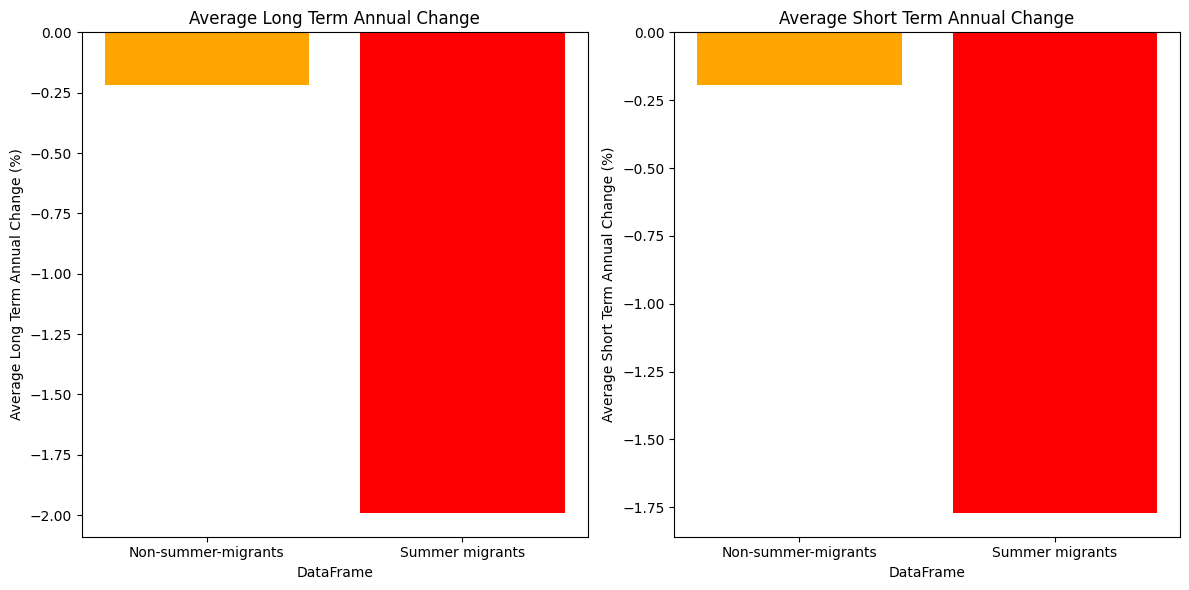

In [30]:

df_avg_long_term = df['Long Term Annual Change'].mean()
df_avg_short_term = df['Short Term Annual Change'].mean()

merged_df_avg_long_term = merged_df['Long Term Annual Change'].mean()
merged_df_avg_short_term = merged_df['Short Term Annual Change'].mean()

avg_df = pd.DataFrame({
    'DataFrame': ['Non-summer-migrants', 'Summer migrants'],
    'Long Term Annual Change': [df_avg_long_term, merged_df_avg_long_term],
    'Short Term Annual Change': [df_avg_short_term, merged_df_avg_short_term]
})

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(avg_df['DataFrame'], avg_df['Long Term Annual Change'], color=['orange', 'red'])
plt.xlabel('DataFrame')
plt.ylabel('Average Long Term Annual Change (%)')
plt.title('Average Long Term Annual Change')

plt.subplot(1, 2, 2)
plt.bar(avg_df['DataFrame'], avg_df['Short Term Annual Change'], color=['orange', 'red'])
plt.xlabel('DataFrame')
plt.ylabel('Average Short Term Annual Change (%)')
plt.title('Average Short Term Annual Change')

plt.tight_layout()
plt.show()

Could this be down to their preferred breeding habitat rather than migrant status? Woodland specialist is the most common habitat type among summer migrants and we've seen that there are a greater proportion of specialists in decline. 

In [31]:
merged_df['Type'].value_counts()

Type
Woodland Specialists (22)                                   9
Other species included in the all species indicator (31)    6
Water and wetland Reedbed Birds (4)                         2
Farmland Specialists (12)                                   2
Farmland Generalists (7)                                    1
Water and wetland Birds of fast flowing water (4)           1
Woodland Generalists (12)                                   1
Wetland Birds (8)                                           1
Other Species (4)                                           1
Name: count, dtype: int64


However, the analysis below suggests that migratory woodland specialists are at greater risk of population decline than resident or winter migrant woodland specialists.

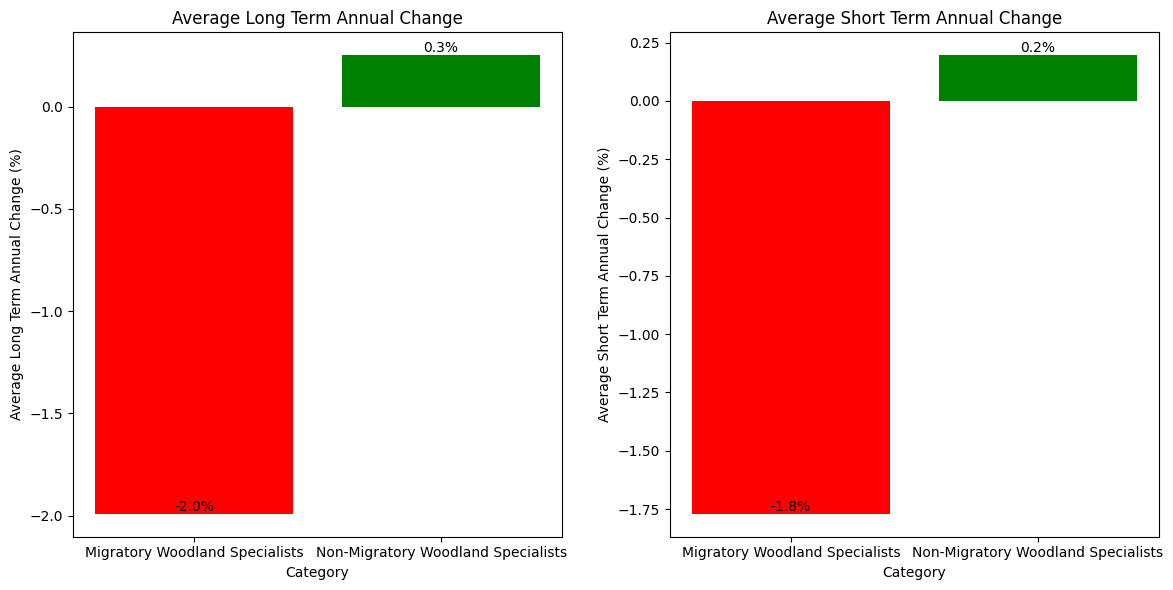

In [32]:
migratory_woodland_specialists = merged_df[merged_df['Species'].isin(merged_df['Species'])]

non_migratory_woodland_specialists = df[~df['common_name_cleaned'].isin(merged_df['Species'])]

migratory_avg_long_term = migratory_woodland_specialists['Long Term Annual Change'].mean()
migratory_avg_short_term = migratory_woodland_specialists['Short Term Annual Change'].mean()

non_migratory_avg_long_term = non_migratory_woodland_specialists['Long Term Annual Change'].mean()
non_migratory_avg_short_term = non_migratory_woodland_specialists['Short Term Annual Change'].mean()

avg_comparison_df = pd.DataFrame({
    'Category': ['Migratory Woodland Specialists', 'Non-Migratory Woodland Specialists'],
    'Long Term Annual Change': [migratory_avg_long_term, non_migratory_avg_long_term],
    'Short Term Annual Change': [migratory_avg_short_term, non_migratory_avg_short_term]
})

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
bars = plt.bar(avg_comparison_df['Category'], avg_comparison_df['Long Term Annual Change'], color=['red', 'green'])
plt.xlabel('Category')
plt.ylabel('Average Long Term Annual Change (%)')
plt.title('Average Long Term Annual Change')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', 
             ha='center', va='bottom')

plt.subplot(1, 2, 2)
bars = plt.bar(avg_comparison_df['Category'], avg_comparison_df['Short Term Annual Change'], color=['red', 'green'])
plt.xlabel('Category')
plt.ylabel('Average Short Term Annual Change (%)')
plt.title('Average Short Term Annual Change')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

Furthermore there are a greater proportion of (summer) migratory specialists of any kind (woodland or farmland) in decline compared to non-migratory/winter migrant specialists

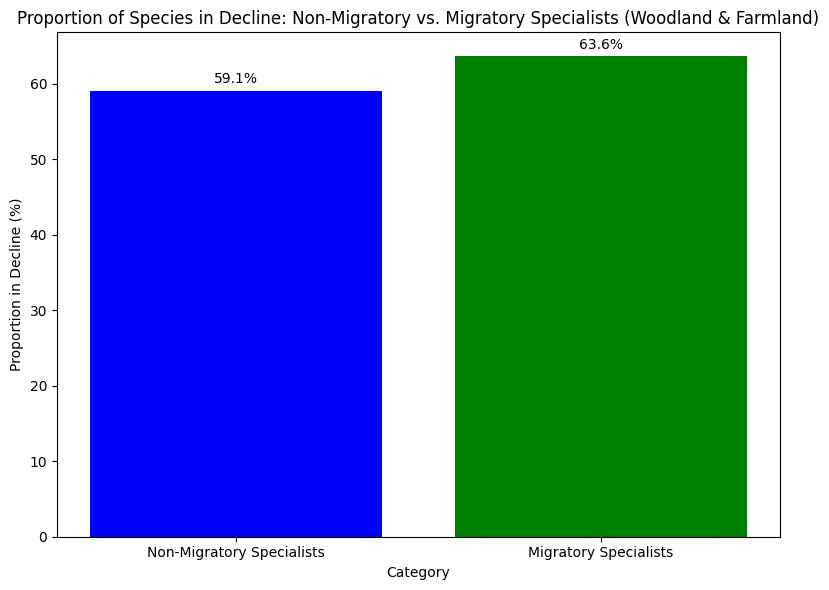

Non-Migratory Decline Species: {'Willow Tit', 'Sparrowhawk', 'Linnet', 'Lesser Spotted Woodpecker', 'Grey Partridge', 'Green Woodpecker', 'Skylark', 'Marsh Tit', 'Starling', 'Yellowhammer', 'Tree Sparrow', 'Lesser Redpoll', 'Lapwing'}
Migratory Decline Species: {'Tree Pipit', 'Willow Warbler', 'Wood Warbler', 'Nightingale', 'Garden Warbler', 'Turtle Dove', 'Spotted Flycatcher'}
Non-Migratory Specialist Count: 22
Migratory Specialist Count: 11


In [33]:
specialists_df = df[df['Type'].str.contains('specialist', case=False, na=False)]

migratory_specialists = specialists_df[specialists_df['common_name_cleaned'].isin(merged_df['Species'])]
non_migratory_specialists = specialists_df[~specialists_df['common_name_cleaned'].isin(merged_df['Species'])]

def get_unique_decline_species(df):
    # Combine trends for uniqueness
    decline_species = set(df[
        (df['Trend'].str.contains('decline', case=False, na=False)) | 
        (df['Trend.1'].str.contains('decline', case=False, na=False))
    ]['common_name_cleaned'].unique())
    return decline_species

non_migratory_decline_species = get_unique_decline_species(non_migratory_specialists)
migratory_decline_species = get_unique_decline_species(migratory_specialists)

non_migratory_proportion_decline = len(non_migratory_decline_species) / len(non_migratory_specialists['common_name_cleaned'].unique()) * 100 if len(non_migratory_specialists) > 0 else 0
migratory_proportion_decline = len(migratory_decline_species) / len(migratory_specialists['common_name_cleaned'].unique()) * 100 if len(migratory_specialists) > 0 else 0

comparison_df = pd.DataFrame({
    'Category': ['Non-Migratory Specialists', 'Migratory Specialists'],
    'Proportion in Decline (%)': [non_migratory_proportion_decline, migratory_proportion_decline]
})

plt.figure(figsize=(8, 6))
plt.bar(comparison_df['Category'], comparison_df['Proportion in Decline (%)'], color=['blue', 'green'])
plt.xlabel('Category')
plt.ylabel('Proportion in Decline (%)')
plt.title('Proportion of Species in Decline: Non-Migratory vs. Migratory Specialists (Woodland & Farmland)')

for i, value in enumerate(comparison_df['Proportion in Decline (%)']):
    plt.text(i, value + 1, f'{value:.1f}%', ha='center')

plt.tight_layout()
plt.show()

print("Non-Migratory Decline Species:", non_migratory_decline_species)
print("Migratory Decline Species:", migratory_decline_species)
print("Non-Migratory Specialist Count:", len(non_migratory_specialists['common_name_cleaned'].unique()))
print("Migratory Specialist Count:", len(migratory_specialists['common_name_cleaned'].unique()))



Most habitats see the proportion of summer migratory species in decline exceeding the proportion of non-migratory (or winter migrants) in decline.  

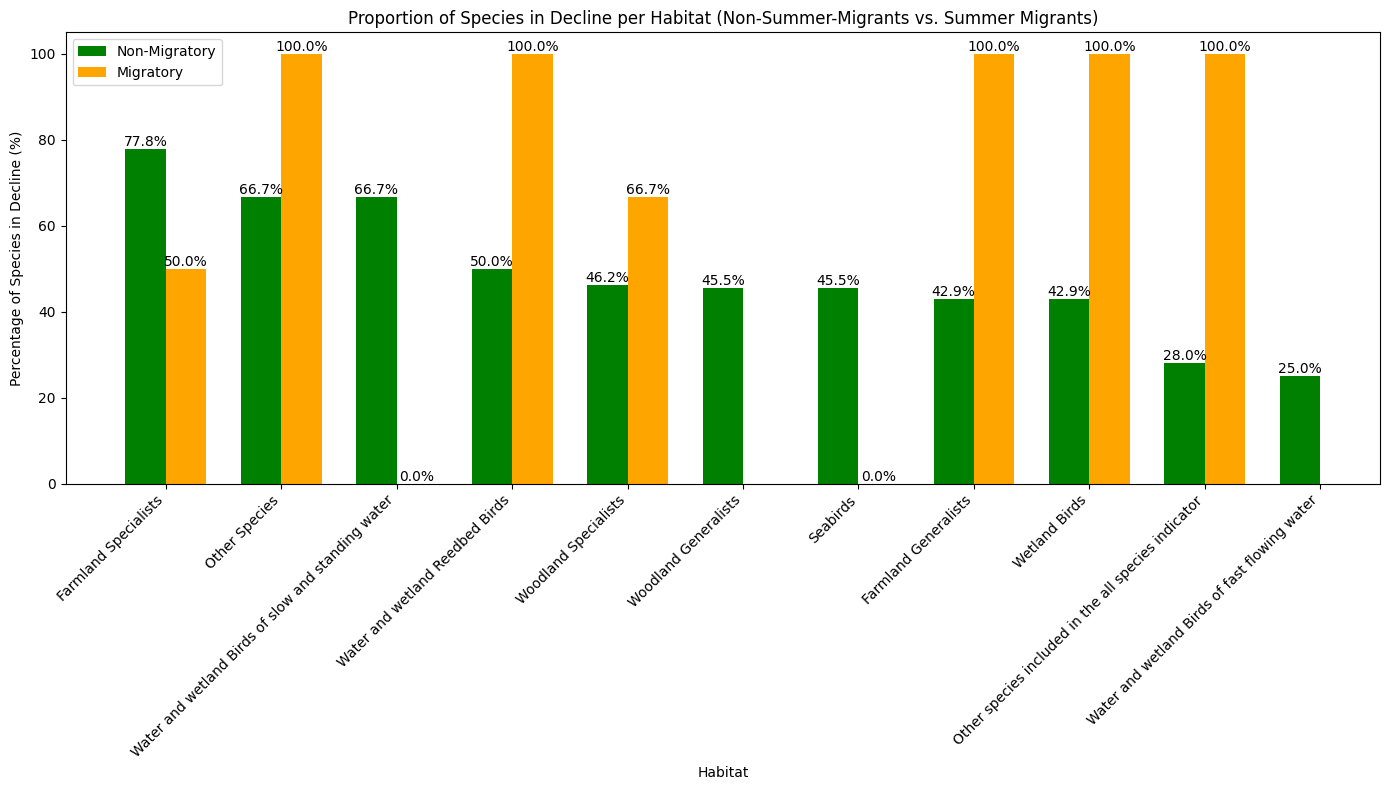

In [34]:

non_migratory_df = df[~df['common_name'].isin(merged_df['Species'])].copy()

non_migratory_df['In Decline'] = (
    non_migratory_df['Trend'].isin(['strong decline', 'weak decline']) |
    non_migratory_df['Trend.1'].isin(['strong decline', 'weak decline'])
)

decline_species_non_migratory = non_migratory_df[non_migratory_df['In Decline']]

decline_counts_non_migratory = decline_species_non_migratory.groupby('Type')['Species'].nunique()

total_counts_non_migratory = non_migratory_df.groupby('Type').size()

proportions_non_migratory = (decline_counts_non_migratory / total_counts_non_migratory) * 100

migratory_df = merged_df.copy()

migratory_df['In Decline'] = (
    migratory_df['Trend'].isin(['strong decline', 'weak decline']) |
    migratory_df['Trend.1'].isin(['strong decline', 'weak decline'])
)

decline_species_migratory = migratory_df[migratory_df['In Decline']]

decline_counts_migratory = decline_species_migratory.groupby('Type')['Species'].nunique()

total_counts_migratory = migratory_df.groupby('Type').size()

proportions_migratory = (decline_counts_migratory / total_counts_migratory) * 100

all_habitats = sorted(set(proportions_non_migratory.index).union(set(proportions_migratory.index)))
combined_proportions = {
    'Habitat': [],
    'Category': [],
    'Proportion in Decline': []
}

for habitat in all_habitats:
    combined_proportions['Habitat'].append(habitat)
    combined_proportions['Category'].append('Non-Migratory')
    combined_proportions['Proportion in Decline'].append(proportions_non_migratory.get(habitat, 0))
    
    combined_proportions['Habitat'].append(habitat)
    combined_proportions['Category'].append('Migratory')
    combined_proportions['Proportion in Decline'].append(proportions_migratory.get(habitat, 0))

proportions_df = pd.DataFrame(combined_proportions)

pivot_df = proportions_df.pivot(index='Habitat', columns='Category', values='Proportion in Decline')

pivot_df_sorted = pivot_df.sort_values(by='Non-Migratory', ascending=False)

def clean_labels(labels):
    return [label.split(' (')[0] for label in labels]

plt.figure(figsize=(14, 8))

bar_width = 0.35
bar_positions = range(len(pivot_df_sorted.index))

bars_non_migratory = plt.bar([p - bar_width/2 for p in bar_positions], pivot_df_sorted['Non-Migratory'], bar_width, label='Non-Migratory', color='green')
bars_migratory = plt.bar([p + bar_width/2 for p in bar_positions], pivot_df_sorted['Migratory'], bar_width, label='Migratory', color='orange')

plt.xlabel('Habitat')
plt.ylabel('Percentage of Species in Decline (%)')
plt.title('Proportion of Species in Decline per Habitat (Non-Summer-Migrants vs. Summer Migrants)')

for bars in [bars_non_migratory, bars_migratory]:
    for bar in bars:
        height = bar.get_height()
        if pd.notna(height) and not pd.isnull(height):
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')

plt.xticks([p for p in bar_positions], clean_labels(pivot_df_sorted.index), rotation=45, ha='right')

plt.legend()
plt.tight_layout()  
plt.show()